## LSTM

### Imports

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
import keras
import tensorflow as tf
from keras.layers import LSTM
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Load data

In [2]:
df1 = pd.read_json("./data/Sarcasm_Headlines_Dataset.json", lines=True)
df2 = pd.read_json("./data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
# re-order attibute columns in df2
df2 = df2[['article_link','headline','is_sarcastic']]
df = pd.concat([df1, df2], axis=0)
df = df.drop(['article_link'], axis=1)
print(len(df))
df.head()

55328


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df['len'] = df['headline'].apply(lambda x: len(x.split(" ")))
print(df['len'].mean())
print(min(df['len']))
print(max(df['len']))

9.953368999421631
2
151


In [4]:
max_features = 10000 # max num words
maxlen = 25 # we could also try 151
embedding_size = 200

# create the tokenizer with the maximum number of words to keep, 
# based on word frequency. 
# Only the most common num_words-1 words will be kept.
tokenizer = Tokenizer(num_words=max_features)
# fit the tokenizer on the headlines
tokenizer.fit_on_texts(list(df['headline']))
# Transforms each text in texts to a sequence of integers.
X = tokenizer.texts_to_sequences(df['headline'])
# transforms a list of num_samples sequences (lists of integers)
# into a 2D Numpy array of shape (num_samples, num_timesteps).
X = pad_sequences(X, maxlen = maxlen)
y = df['is_sarcastic']

Load glove embedding set, construct embedding matrix for words in word_index:


In [5]:
# load embeddings
EMBEDDING_FILE = './embeddings/glove.6B.200d.txt'

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open(EMBEDDING_FILE, encoding="utf8") as f:
    for line in f:
        word, coefs = get_coefs(*line.split(" "))
        embeddings_index[word] = coefs
            
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

# Random embedding vector for unknown words.
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
# prepare embedding matrix
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        # words not found in embedding index will be random
        embedding_matrix[i] = embedding_vector

C:\Users\elsas\Anaconda3\envs\TFM\lib\site-packages\IPython\core\interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### LSTM Model
Model Parameters:

- **Activation Function**: I have used ReLU as the activation function. ReLU is a non-linear activation function, which helps complex relationships in the data to be captured by the model.

- **Optimiser**: We use adam optimiser, which is an adaptive learning rate optimiser.

- **Loss function**: We will train a network to output a probability over the 2 classes using Sigmoid Loss.

In [21]:
# Create model structure

model = Sequential()
model.add(Embedding(max_features, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.TruePositives()])


# Fit the model
batch_size = 100
epochs = 5

metrics=ModelMetrics()
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

C:\Users\elsas\Anaconda3\envs\TFM\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 76s 2ms/step - loss: 0.4680 - accuracy: 0.7607 - precision_7: 0.7631 - recall_7: 0.6863 - true_positives_1: 13802.0000 - val_loss: 0.2420 - val_accuracy: 0.9001 - val_precision_7: 0.8886 - val_recall_7: 0.9026 - val_true_positives_1: 4736.0000
Epoch 2/5
44262/44262 [==============================] - 72s 2ms/step - loss: 0.2277 - accuracy: 0.9175 - precision_7: 0.9100 - recall_7: 0.9082 - true_positives_1: 18265.0000 - val_loss: 0.1702 - val_accuracy: 0.9356 - val_precision_7: 0.9572 - val_recall_7: 0.9045 - val_true_positives_1: 4746.0000
Epoch 3/5
44262/44262 [==============================] - 73s 2ms/step - loss: 0.1342 - accuracy: 0.9557 - precision_7: 0.9538 - recall_7: 0.9483 - true_positives_1: 19072.0000 - val_loss: 0.1237 - val_accuracy: 0.9551 - val_precision_7: 0.9771 - val_recall_7: 0.9270 - val_true_positives_1: 4864.0000
Epoch 4/5
44262/44262 [========================

#### Accuracy, Precision, Recall and F1

In [26]:
print("Accuracy:")
print(history.history['val_accuracy'])
print("Precision:")
print(history.history['val_precision_7'])
print("Recall:")
print(history.history['val_recall_7'])
print("F1:")
mult=[a*b for a,b in zip(history.history['val_precision_7'],history.history['val_recall_7'])]
sum=[a+b for a,b in zip(history.history['val_precision_7'],history.history['val_recall_7'])]
div=[a/b for a,b in zip(mult,sum)]
f1_score=[2*a for a in div]
print(f1_score)

Accuracy:
[0.9001445770263672, 0.9355683922767639, 0.9550876617431641, 0.9730706810951233, 0.9796674251556396]
Precision:
[0.8885553479194641, 0.9572408199310303, 0.9770992398262024, 0.9787192940711975, 0.990813136100769]
Recall:
[0.9026110172271729, 0.904516875743866, 0.9270058870315552, 0.964169979095459, 0.9660758376121521]
F1:
[0.8955280336369796, 0.9301322914254324, 0.9513936334257991, 0.9713901603532139, 0.9782881330865904]


#### Plot Model loss and accuracy

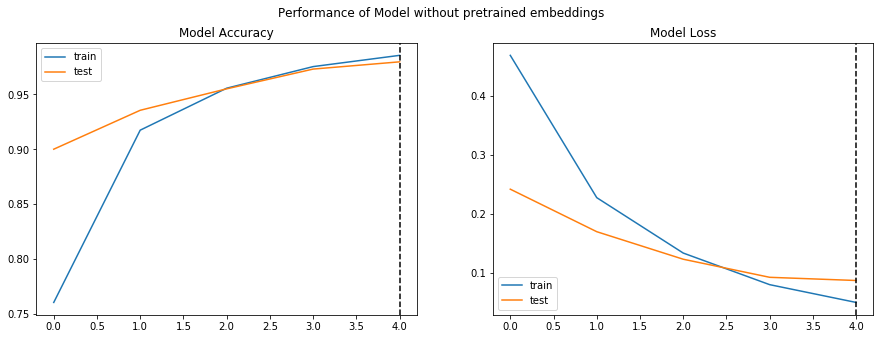

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model without pretrained embeddings")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()